# Model Architecture

We have 4000 total labeled sample images in total to work with. That means 2000 fire images and 2000 non-fire images. Among them I have used 3000 images for training and 1000 for testing equally splitting among both the labels. Although this dataset is of decent size, it is not enough to train the model from scratch using keras model. And as we see later it is not necessary as well. Instead we can use some of the pretrained model. 

I use VGG16 pretrained model. VGG-16 is a trained Convolutional Neural Network (CNN), from Visual Geometry Group (VGG), Department of Engineering Science, University of Oxford. The number 16 means the number of layers with trainable weights. The reference paper is here: 

https://arxiv.org/abs/1409.1556



A review article is here: 

https://neurohive.io/en/popular-networks/vgg16/


Pretrained model are trained in different data, not necessarily similar to the data we are training in this model. But we can still use it because of the follwing reason: The CNN has series of layers. Each layer learns a set of features from the image data. The lower layers learn fundamental patterns like edeges, lines, curves etc. The higher layers on the other hand are specific to the images on the model. Hence, the featured learned by the lower level can be general to the large class of images, even the images which model did not see during its training. Because of this reason we only use the base of the pre-trained model removing the top. We do this here in two steps. 

First, we retain all the base and remove only the dense top layer and train the model. Which gives us validation accuracy close to 90%. And in second step, we unlock the top convolutional model on the base and further train the model. Since we already have a decent accuracy we can imagine that the model is already close to the optimum model. So we only need to fine tune. For this reason we drop the learning rate to 10% of the previous case and train for larger number of iterations. Doing so we achieve a validation accuracy close to 97%. Which is pretty decent result. 

#### Importing packages 

In [1]:
import os                                     # operating system 
import numpy as np                            # linear algebra 
from PIL import Image                         # Python image library 
import matplotlib.pyplot as plt               # making plots
%matplotlib inline 
from IPython.display import display           # displaying ?

import warnings                               # ignoring unnecessary python warnings 
warnings.filterwarnings('ignore')

from keras.applications import VGG16                         # pretrained CNN                        
from keras.callbacks import ModelCheckpoint                  # furter train the saved model 
from keras import models, layers, optimizers                 # building DNN is keras 
from tensorflow.keras.models import load_model               # load saved model 
from keras.preprocessing.image import ImageDataGenerator     # preparing image data for training 

Using TensorFlow backend.


#### Setting up model 

We set the model with VGG16 base and custom top. 

- Loss: Since this is classification problem and there are two classes, we use the binary cross-entropy as the loss function. 

- Optimizer: We use RMSprop optimizer with customized learning rate. 

- Metrics: In addition to the loss we want to observe the accuracy. We optimize our model based on this metric.

In [4]:
conv_base = VGG16(weights='imagenet', 
                 include_top=False,
                 input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4), 
             metrics=['acc'])

Here is the summary of the model. 

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


# Preparing the data 

#### Calling test and train image directories 

These directories were prepared in the other notebook. 

In [3]:
base_dir = 'D:/Projects/Fire_detection'

train_dir = os.path.join(base_dir, 'train')
train_dir_fire = os.path.join(train_dir, 'fire')
train_dir_nofire = os.path.join(train_dir, 'nofire')

test_dir = os.path.join(base_dir, 'test')
test_dir_fire = os.path.join(test_dir, 'fire')
test_dir_nofire = os.path.join(test_dir, 'nofire')

#### Data generator & data augmentation 

For the large dataset it is not convenient to load all the data into memory. So we use image data generator to load the data from hard disc to memory in small batch. We do the same of the training and test set. 

Further, when initiating the image data generator we can do the data augmentation. This is the step to create more data from existing data by transforming the image. This artificially provides more data to train. Here we use rotation, translation, shear, zooming and horizontal flip for data augmentation. Other transformations like verticle flip is not suitable. We only do the data augmentation in the training set and not on the validation and test set. 

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


# Training the model 

We pass the training data from the train_generator. We train for 30 epochs. We pass the validation data from the validation_generator.  We get validation accuracy above to 90% from this. 

In [6]:
history = model.fit(train_generator, epochs=30, 
                    validation_data=test_generator)

Epoch 1/30
94/94 [==============================] - 66s 704ms/step - loss: 0.5043 - acc: 0.7510 - val_loss: 0.3089 - val_acc: 0.8034
Epoch 2/30
94/94 [==============================] - 68s 724ms/step - loss: 0.4152 - acc: 0.8173 - val_loss: 0.2592 - val_acc: 0.8463
Epoch 3/30
94/94 [==============================] - 67s 716ms/step - loss: 0.3622 - acc: 0.8457 - val_loss: 0.8562 - val_acc: 0.8653
Epoch 4/30
94/94 [==============================] - 61s 654ms/step - loss: 0.3459 - acc: 0.8500 - val_loss: 0.1767 - val_acc: 0.8743
Epoch 5/30
94/94 [==============================] - 69s 731ms/step - loss: 0.3311 - acc: 0.8560 - val_loss: 0.1344 - val_acc: 0.8623
Epoch 6/30
94/94 [==============================] - 63s 675ms/step - loss: 0.3322 - acc: 0.8460 - val_loss: 0.2074 - val_acc: 0.8693
Epoch 7/30
94/94 [==============================] - 68s 727ms/step - loss: 0.3100 - acc: 0.8700 - val_loss: 0.4602 - val_acc: 0.8303
Epoch 8/30
94/94 [==============================] - 59s 627ms/step - 

Saving the model for the future use. 

In [7]:
model.save('VGG16_lr-4.h5')

#### Visualization of the learning 

Training gives four sets of values in each eopch

- Training accuracy 
- Validation accuracy 
- Training loss 
- Validation loss 

In [17]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

#### Function to make plot 

In [19]:
def plot_func(entity):
    
    '''
    This function produces plot to compare the performance 
    between train set and validation set. 
    entity can be loss of accuracy. 
    '''
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

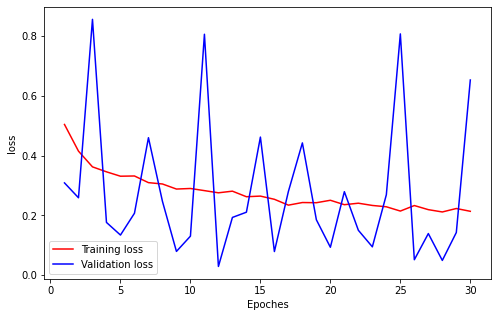

In [20]:
plot_func('loss')

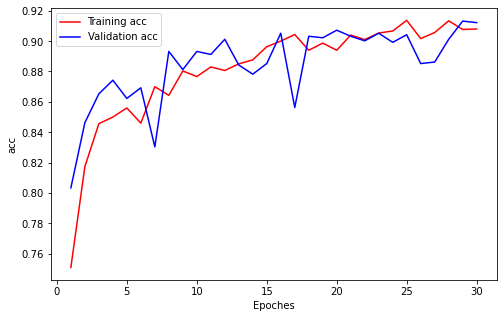

In [21]:
plot_func('acc')

# Fine tuning the model

#### Unlocking the top convolutional block 

We trained previosuly with only top layer removed from VGG16. Here we unlock top base layer from VGG16 and fine tune the model. Doing so we reduce the learning rate from $10^{-4}$ to $10^{-5}$. We train for the 50 epoches. The model surpass the validation accuracy of 97% shortly after 30 epochs. It is not unlikely to improve the model after 50 epochs. But I am happy with this for now. The future plan is to check with other pre-trained model rather. 

In [22]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        set_trainable = False
    
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-5), 
             metrics=['acc'])

#### Fitting the model 

In [24]:
history = model.fit_generator(train_generator, epochs=50, 
                             validation_data=test_generator)

Epoch 1/50
94/94 [==============================] - 74s 791ms/step - loss: 0.2305 - acc: 0.9077 - val_loss: 0.5732 - val_acc: 0.9202
Epoch 2/50
94/94 [==============================] - 67s 710ms/step - loss: 0.1753 - acc: 0.9330 - val_loss: 0.0323 - val_acc: 0.9431
Epoch 3/50
94/94 [==============================] - 161s 2s/step - loss: 0.1398 - acc: 0.9450 - val_loss: 0.0247 - val_acc: 0.9441
Epoch 4/50
94/94 [==============================] - 223s 2s/step - loss: 0.1181 - acc: 0.9560 - val_loss: 0.0026 - val_acc: 0.8842
Epoch 5/50
94/94 [==============================] - 246s 3s/step - loss: 0.1106 - acc: 0.9550 - val_loss: 0.0489 - val_acc: 0.9461
Epoch 6/50
94/94 [==============================] - 253s 3s/step - loss: 0.0985 - acc: 0.9637 - val_loss: 0.6680 - val_acc: 0.9521
Epoch 7/50
94/94 [==============================] - 234s 2s/step - loss: 0.0783 - acc: 0.9713 - val_loss: 0.8009 - val_acc: 0.9481
Epoch 8/50
94/94 [==============================] - 144s 2s/step - loss: 0.0692

In [27]:
model.save('VGG16_fine_tuned.h5')

#### Visualization of fine tuning process

In [36]:
hist_dict = history.history

training_accuracy = hist_dict['acc']
validation_accuracy = hist_dict['val_acc']

training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

epoches = range(1, 1 + len(training_acc))

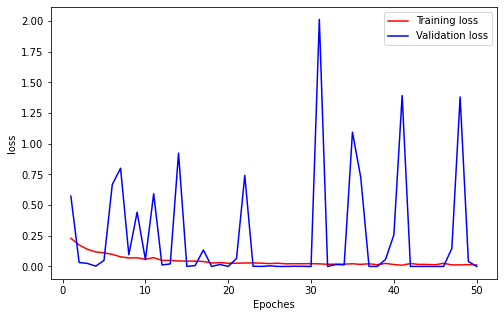

In [34]:
plot_func('loss')

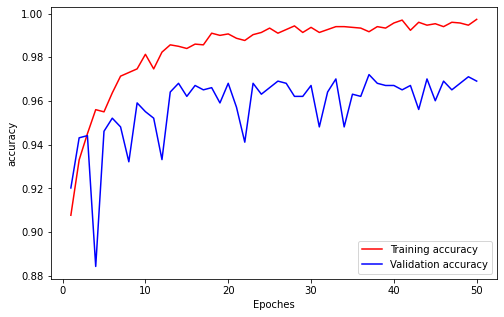

In [37]:
plot_func('accuracy')

# Error Analysis

In this section we analyze the error of the model, i.e. mis-classified images. We first see few examples of the correctly classified images. Then we visualize the confusion matrix. And finally, we see separately fire images classified as non-fire and non-fire images classified as fire.  

In [6]:
# Loading the saved model 
model = load_model('VGG16_fine_tuned.h5')

#### Getting the labels and predictions 

In [46]:
# taking first batch from the generator 
img, label = test_generator[0] 

# Predicting the images from the first batch 
pred = np.round(model.predict(img)).flatten()

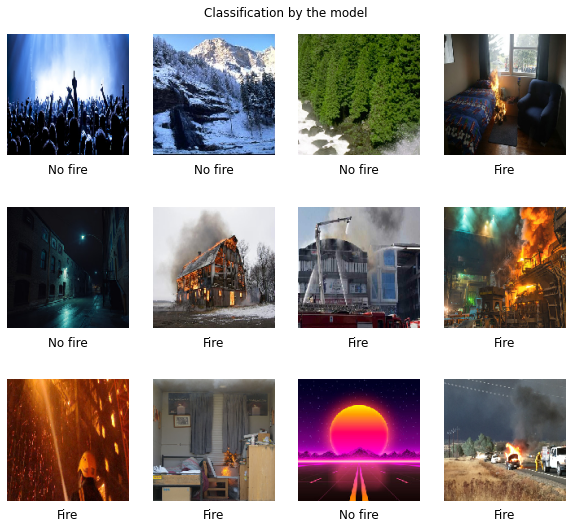

In [47]:
# Numeric to semantic labels 
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:12]):
    ax = fig.add_subplot(3, 4, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

#### Extracting misclassified images

In [11]:
# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

# Iterating through all the batches 
for j in range(31):
    img, label = test_generator[j] 
    pred = np.round(model.predict(img)).flatten()
    bool_list = label == pred

    # bool_list is False when there is misclassification 
    for i, e in enumerate(bool_list):
        if e == False:
            
            # separating labels (fire and non-fire)
            if label[i] == 0:
                msd_fire.append(img[i])
            else:
                msd_nofire.append(img[i])

#### Confusion matrix

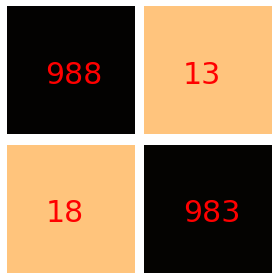

In [124]:
# total number of sample in train set in each class 
n_class = 1001

# number of misclassified fire and non-fire images 
nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# confusion matrix (flattened)
conf_mat = [n_class-nm_fire, nm_fire, nm_nofire, n_class-nm_nofire]

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

#### Showing mis-classified fire images 

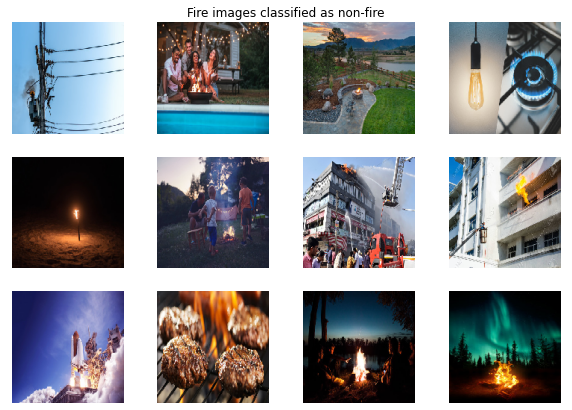

In [114]:
fig = plt.figure(figsize=(10, 7))
plt.title('Fire images classified as non-fire')
plt.axis('off')
for i, img_i in enumerate(msd_fire[:7] + msd_fire[8:]):        
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(img_i)
    ax.axis('off')

#### Showing mis-classified non-fire images. 

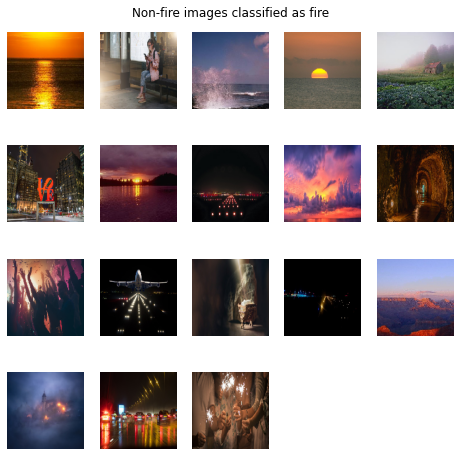

In [113]:
fig = plt.figure(figsize=(8, 8))
plt.title('Non-fire images classified as fire')
plt.axis('off')
for i, img_i in enumerate(msd_nofire[:20]):        
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

# Option to further train the model 

In tesorflow it is possible to firther train the save model. We need to initiate the checkpoint by imporing the saved model. After that we can fit the model again by passing in callbacks argument, which takes the values from the callbacks_list. This method automatically saves the model if it finds the batter performance in further training. 

In [26]:
checkpoint = ModelCheckpoint('VGG16_fine_tuned.h5',
                             monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [27]:
hst_cntd = model.fit(train_generator, epochs=5,
                     steps_per_epoch = 15,
                     validation_data=test_generator, 
                     validation_steps = 30,
                     callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 30 steps
Epoch 1/5
14/15 [===========================>..] - ETA: 0s - loss: 8.1191e-04 - acc: 1.0000
Epoch 00001: loss improved from inf to 0.00126, saving model to VGG16_fine_tuned.h5
15/15 [==============================] - 22s 1s/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1731 - val_acc: 0.9677
Epoch 2/5
14/15 [===========================>..] - ETA: 0s - loss: 0.0065 - acc: 0.9978
Epoch 00002: loss did not improve from 0.00126
15/15 [==============================] - 23s 2s/step - loss: 0.0060 - acc: 0.9979 - val_loss: 0.2228 - val_acc: 0.9677
Epoch 3/5
14/15 [===========================>..] - ETA: 0s - loss: 0.0171 - acc: 0.9955
Epoch 00003: loss did not improve from 0.00126
15/15 [==============================] - 23s 2s/step - loss: 0.0163 - acc: 0.9958 - val_loss: 0.2401 - val_acc: 0.9646
Epoch 4/5
14/15 [===========================>..] - ETA: 0s - loss: 8.0089e-04 - acc: 1.0000
Epoch 00004: 

# Future direction 

- Although the accuracy is good VGG16 is large and slow to train. 

- Try other pre-trained networks: Xception (smaller size higher accuracy), MobileNet (much smaller in size with comparable accuracy). Look here: https://keras.io/api/applications/

- Have test, train and validation split: So far there is only test and validation set.